<a href="https://colab.research.google.com/github/NikBarykin/PythonTPIMLab/blob/master/Copy_of_lab_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа

Баллы за секции:
- *Задание 1* - 10 баллов
- *Задание 2* - 20 баллов
- *Задание 3* - 30 баллов
- **Итого** - 60 баллов

Оценка за лабу $ = \frac{score}{6}$

## Внимание! Attention! Achtung!

**Данная лабораторная работа является блокирующей**, т.е. если лабораторная работа не выполнена, то оценка за курс - неуд.

Лабораторная работа считается выполненной, если **за каждое из заданий получено не менее 2 баллов**.

## Формат сдачи лабораторной работы

Данная лабораторная работа сдается так же, как и проект - заполняете данный ноутбук, отправляете его через GitHub с указанием проверяющего.

**Ассистенты не будут запускать ячейки кода, а смотреть на выведенный результат и код. Если ячейка кода не запущена - балл не ставится, даже при правильно написанном коде.**

***(Комментарии что курс по Python легче чем по C++ учтены)***

>**Примечание**
>
>Данные задания вдохновлены предметом "Введение в анализ данных" 2 курса, по итогу которого идёт отбор на DS-поток. Если вы видите себя в смежных областях, советуем выполнить данную лабораторку по максимуму.

In [2]:
# Всё необходимое для выполнения данной лабораторной работы!
import requests
from time import sleep

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Задание 1. Парсинг - 10 баллов

В этом задании Вам предстоит работать с API сайта <a target="_blank" href="hh.ru">hh.ru</a>. Документация доступна по <a target="_blank" href="https://github.com/hhru/api/blob/master/docs/vacancies.md#search">ссылке</a>.

<b><font color="red">Внимание!</font> При работе с API не забывайте делать паузы между запросами, иначе вас забанят. Просрочка дедлайна по этой причине не принимается!</b>

**Задача:**
1. выбрать 5 интересующих вас профессий (не смежных, т.е. Аналатик и Data Engineer не считается корректным)
2. затем получить доступные по данным профессиям вакансии в Москве и выделить их физические координаты
3. нанести полученные координаты на карту местоположения компаний

*Пример запроса для профессии:*

In [3]:
URL = 'https://api.hh.ru/vacancies'

params = {
    'text': "C++ программист",
    'area': 1,
    'page': 0,
    'per_page': 10
}

data = requests.get(URL, params).json()

Если Ваш запрос прошел успешно, то вы получите следующие ключи (значения данных ключей вы найдете по ссылке на документацию):

In [4]:
data.keys()

dict_keys(['items', 'found', 'pages', 'per_page', 'page', 'clusters', 'arguments', 'alternate_url'])

>**Примечание**
>
>В `data['pages']` будет хранится количество найденных страниц вакансий - для корректного сбора данных Вам нужно пробежать по **КАЖДОЙ** странице и сделать соотвествующие запросы.

>**Совет**
>
>Посмотрите что хранится в `items`!

(1 балл) Выберете для нас 5 наиболее интересных специальностей и получите по ним имеющиеся вакансии:

In [5]:
from random import random

def request_vacancies(params):
  sleep(0.3 + random())
  return requests.get(URL, params).json()

In [6]:
def get_vacancies(profession: str):
  params = {
    'text': profession,
    'area': 1,
    'page': 0,
    'per_page': 100
  }

  initial_data = request_vacancies(params)
  no_pages = initial_data['pages']

  result = []
  for page_i in range(no_pages):
    params['page'] = page_i
    result += request_vacancies(params)['items']
  return result

In [7]:
interesting_professions = ['Python-программист', 'Охранник', 'Ветеринар', 'Машинист', 'Продавец']

In [8]:
profession_vacancies = dict()
for profession in interesting_professions:
  profession_vacancies[profession] = get_vacancies(profession)

In [9]:
import itertools

vacancies = list(itertools.chain.from_iterable(profession_vacancies.values()))

(1 балл) Посчитайте сколько всего найдено вакансий:

In [10]:
len(vacancies)

4607

(1 балл) Создайте структуру данных, которая будет хранить в себе имя компании и ее координаты (широта и долгота):

In [11]:
from typing import Optional


def vacancy_latitude(vacancy) -> Optional[float]:
  return (None if vacancy['address'] is None 
          else vacancy['address']['lat'])

def vacancy_longitude(vacancy) -> Optional[float]:
  return (None if vacancy['address'] is None 
          else vacancy['address']['lng'])

In [12]:
from dataclasses import dataclass


@dataclass(frozen=True)
class Company:
  name: str
  latitude: Optional[float]
  longitude: Optional[float]

  def coordinated(self) -> bool:
    return self.latitude is not None and self.longitude is not None

  def from_vacancy(vacancy):
    name = vacancy['employer']['name']
    lat = vacancy_latitude(vacancy)
    lng = vacancy_longitude(vacancy)
    return Company(name, lat, lng)

(1 балл) Создайте экземпляр этой структуры данных для каждой компании, которая выставила вакансию:

In [13]:
companies = set(Company.from_vacancy(vacancy) for vacancy in vacancies)

(1 балл) Найдите количество вакансий, у которых заданы координаты (значения данных может быть пустым):

In [14]:
def coordinated_vacancy(vacancy) -> bool:
  return Company.from_vacancy(vacancy).coordinated()

In [15]:
coordinated_vacancies = list(filter(coordinated_vacancy, vacancies))
len(coordinated_vacancies)

2979

(1 балл) Отберите вакансии, которые расположены в пределах МКАД (можно грубо):

In [16]:
import math

CREMLIN_LAT = 55.751999
CREMLIN_LNG = 37.617734
CREMLIN_COORDS = (CREMLIN_LAT, CREMLIN_LNG)
NOVOGIREEVO_COORDS = (55.7509995, 37.8050003)
CONTROL_DISTANCE = math.dist(CREMLIN_COORDS, NOVOGIREEVO_COORDS)

In [17]:
def vacancy_in_MRR(vacancy) -> bool:
  """Вакансия в пределах МКАД, если она не дальше от Кремля, чем ст. Новогиреево"""
  coords = (vacancy_latitude(vacancy), vacancy_longitude(vacancy))
  return math.dist(CREMLIN_COORDS, coords) < CONTROL_DISTANCE

In [18]:
vacancies_in_MRR = list(filter(vacancy_in_MRR, coordinated_vacancies))

(1 балл) Постройте график в координатах "широта-долгота" для отображения вакансий внутри МКАД (не забывайте прописать прозрачность, чтобы увидеть скопления):

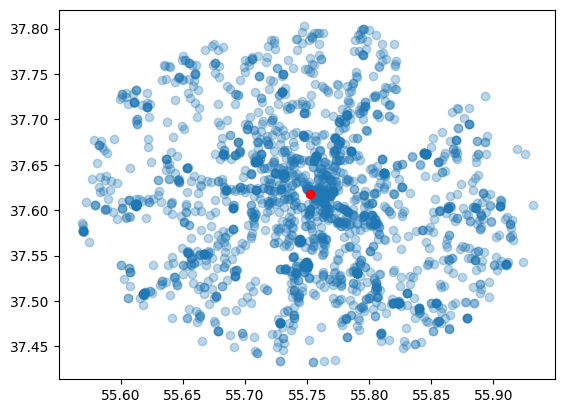

In [19]:
latitudes = list(map(vacancy_latitude, vacancies_in_MRR))
longitudes = list(map(vacancy_longitude, vacancies_in_MRR))

plt.scatter(latitudes, longitudes, alpha=0.3)
plt.scatter(CREMLIN_LAT, CREMLIN_LNG, color='red')

(1 балл) Нанесите все точки вакансий на карту (для этого вам поможет данная <a target="_blank" href="https://plotly.com/python/mapbox-layers/">документации</a>, не забудьте про прозрачность и центрирование по Москве): 

In [20]:
import plotly.express as px

fig = px.scatter_mapbox(list(zip(latitudes, longitudes)), lat=0, lon=1,
                        color_discrete_sequence=["fuchsia"], zoom=10,
                        height=800, width=700,
                        center={"lat": CREMLIN_LAT, "lon": CREMLIN_LNG},
                        opacity=0.3)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

(2 балла) **Сделайте выводы о проделанной работе:**

>*Подсказки для маленьких: Что вы можете сказать про районы Москвы? Что вы можете сказать про зарплаты? Что вы можете сказать про спрос?*

Ваши выводы здесь :)

## Задание 2. Анализ данных - 20 баллов

Вам предстоит проанализировать датасет, содержащий информацию об бриллианта, их стоимости и остальных характеристиках.



Поясним значения хранящиеся в колонках:
*   `cut` - огранка бриллианта (относится к одной из примерно 10 наиболее распространенных)
*   `color` - цвет бриллианта, прозрачные бриллианты имеют градацию `D-Z`, "более высокие" буквы - более желтоватые, но часто имеют лучшие значения, поскольку цвет трудно определить один раз в кольце
*   `clarity` - чистота бриллианта, наличие включений (внутренних дефектов), чем меньше и мельче, тем лучше
*   `carat_weight` - масса бриллианта (слабо связана с размером бриллианта, т.к. огранка и качество огранки, как правило, играют большую роль)
*   `cut_quality` - качество ограники по системе оценки GIA Cut
*   `lab` - лаборатория оценивания
*   `meas_length` - длина бриллианта
*   `meas_width` - ширина бриллианта
*   `meas_depth` - глубина бриллианта
*   `total_sales_price` - цена бриллианта в долларах.
*    **и прочие колонки**

Скачаем данные:

In [21]:
!gdown 1uIWeZFz3ElB5p1brBVEwJBHTbjXNPdfU

Downloading...
From: https://drive.google.com/uc?id=1uIWeZFz3ElB5p1brBVEwJBHTbjXNPdfU
To: /content/diamonds.csv
100% 35.4M/35.4M [00:00<00:00, 147MB/s]


Создадим DataFrame:

In [22]:
diamonds = pd.read_csv("diamonds.csv")

(0.5 балла) Выведете первые 5 строк датасета:

In [23]:
diamonds.head(5)

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.79,M,M,unknown,None,unknown,unknown,unknown,unknown,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,...,1.78,STK,STK,unknown,None,unknown,unknown,unknown,unknown,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.77,TN,M,unknown,None,unknown,unknown,unknown,unknown,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.78,M,STK,unknown,None,unknown,unknown,unknown,unknown,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,...,1.82,STK,STK,unknown,None,unknown,unknown,unknown,unknown,200


(0.5 балла) Найдите количество бриллиантов всего в данном датасете:

In [24]:
len(diamonds)

219703

(0.5 балла) Выведите максимальную и минимальную цену бриллианта в формате `номер - цена`:

In [25]:
prices = diamonds['total_sales_price']
print(f"Max:\n{prices[prices == prices.max()]}")
print(f"Min:\n{prices[prices == prices.min()]}")

Max:
219702    1449881
Name: total_sales_price, dtype: int64
Min:
0     200
1     200
2     200
3     200
4     200
5     200
6     200
7     200
8     200
9     200
10    200
11    200
12    200
13    200
14    200
15    200
16    200
17    200
18    200
19    200
20    200
21    200
22    200
Name: total_sales_price, dtype: int64


(1 балл) Посчитайте количество пропусков (пропуском считается значение `unknown` или `None`):

In [26]:
omissions = ((diamonds == 'None') | (diamonds == 'unknown'))

In [27]:
omissions.sum().sum()

1891168

(1 балл) Найдите в каких столбцах присутствуют пропуски:

In [28]:
omissions.any()

Unnamed: 0                     False
cut                            False
color                           True
clarity                        False
carat_weight                   False
cut_quality                     True
lab                            False
symmetry                       False
polish                         False
eye_clean                       True
culet_size                      True
culet_condition                 True
depth_percent                  False
table_percent                  False
meas_length                    False
meas_width                     False
meas_depth                     False
girdle_min                      True
girdle_max                      True
fluor_color                     True
fluor_intensity                 True
fancy_color_dominant_color      True
fancy_color_secondary_color     True
fancy_color_overtone            True
fancy_color_intensity           True
total_sales_price              False
dtype: bool

В нашем датасете присутствуют колонки, которые начинаются с `fancy_color_` или `fluor_`. Большинство значений в этих колонках - `unknown` или `None`, поэтому мы считаем их малоинформативными. 

Ваша задача:

1. (0.5 балла) найти количество таких колонок, которые начинаются с `fancy_color_` или `fluor_`:

In [29]:
def get_columns_with_prefix(dataframe, prefix: str):
  return dataframe.columns.str.startswith(prefix)

In [30]:
non_informative = (get_columns_with_prefix(diamonds, 'fancy_color_')
                   | get_columns_with_prefix(diamonds, 'fluor_'))
non_informative.sum()

6

2. (0.5 балла) найти количество информативных (не `None` или `unknown`) значений в этих колонках: 

In [31]:
len(omissions) * non_informative.sum() -  omissions.loc[:, non_informative].sum().sum()

111586

3. (0.5 балла) удалить данные колонки из датасета, сохранив изменения (в дальнейшем работаем измененным датасетом):

In [32]:
diamonds2 = diamonds.loc[:, ~non_informative]
diamonds2.head()

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,culet_size,culet_condition,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,N,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,N,unknown,61.9,59.0,2.84,2.89,1.78,STK,STK,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,unknown,unknown,61.1,59.0,2.88,2.90,1.77,TN,M,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,unknown,unknown,62.0,59.0,2.86,2.88,1.78,M,STK,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,N,unknown,64.9,58.5,2.79,2.83,1.82,STK,STK,200


(1 балл) Проделайте тоже самое для колонок, начинающихся с `culet_`:

In [33]:
diamonds3 = diamonds2.loc[:, ~get_columns_with_prefix(diamonds2, "culet_")]
diamonds3.head()

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,61.9,59.0,2.84,2.89,1.78,STK,STK,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,61.1,59.0,2.88,2.90,1.77,TN,M,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.0,59.0,2.86,2.88,1.78,M,STK,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,64.9,58.5,2.79,2.83,1.82,STK,STK,200


(1 балл) Посчитайте сколько бы стоил (в тысячах долларов) сейф, в котором хранились бы все бриллианты из датасета:

In [34]:
diamonds3['total_sales_price'].sum() / 1000

1517721.991

Немного необоснованных манипуляций.

(1 балл) Выберите из датасета строки с четными индексами и выведете значения (не меняя нумерацию индексов):

In [35]:
diamonds3.loc[diamonds3.index % 2 == 0]

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,61.1,59.0,2.88,2.90,1.77,TN,M,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,64.9,58.5,2.79,2.83,1.82,STK,STK,200
6,6,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,64.0,57.0,2.85,2.88,1.84,STK,STK,200
8,8,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,63.5,59.5,2.89,2.92,1.85,STK,TK,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219694,219695,Round,D,IF,12.52,Excellent,HRD,Excellent,Excellent,unknown,62.1,58.0,14.84,14.91,9.24,unknown,unknown,1121792
219696,219697,Oval,H,VS2,18.88,unknown,GIA,Excellent,Excellent,unknown,57.1,55.0,21.34,15.23,8.69,TN,STK,1132347
219698,219699,Round,E,VS1,10.65,Excellent,GIA,Excellent,Excellent,unknown,61.3,58.0,14.06,14.18,8.66,M,STK,1210692
219700,219701,Round,E,VS1,18.07,Excellent,GIA,Excellent,Excellent,unknown,60.2,59.0,17.06,17.10,10.20,TN,M,1315496


(0.5 балла) А теперь с индексами, кратными 6:

In [36]:
diamonds3.loc[diamonds3.index % 6 == 0]

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
6,6,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,64.0,57.0,2.85,2.88,1.84,STK,STK,200
12,12,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,61.8,58.5,2.85,2.89,1.77,STK,TK,200
18,18,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,61.0,60.0,2.91,2.92,1.78,M,M,200
24,24,Round,L,I1,0.34,Excellent,IGI,Excellent,Excellent,unknown,0.0,0.0,0.00,0.00,0.00,unknown,unknown,204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219678,219679,Round,G,VS1,10.23,Excellent,GIA,Excellent,Excellent,unknown,62.7,55.0,13.82,13.92,8.69,TN,M,859320
219684,219685,Radiant,unknown,I1,0.89,unknown,GIA,Good,Good,unknown,63.8,57.0,6.44,4.96,3.16,TK,VTK,982560
219690,219691,Round,D,VVS2,10.10,Excellent,GIA,Excellent,Excellent,unknown,59.4,59.0,14.07,14.15,8.39,M,STK,1040739
219696,219697,Oval,H,VS2,18.88,unknown,GIA,Excellent,Excellent,unknown,57.1,55.0,21.34,15.23,8.69,TN,STK,1132347


(1 балл) Выберете из датасета только категорильные признаки и выведете датасет:

In [37]:
diamonds4 = diamonds3[['cut', 'color', 'clarity', 'cut_quality', 'lab', 
                       'symmetry', 'polish', 'eye_clean', 
                       'girdle_min', 'girdle_max']]
diamonds4.head()

,cut,color,clarity,cut_quality,lab,symmetry,polish,eye_clean,girdle_min,girdle_max
0,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,unknown,M,M
1,Round,E,VVS2,Very Good,IGI,Very Good,Very Good,unknown,STK,STK
2,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,unknown,TN,M
3,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,unknown,M,STK
4,Round,E,VVS2,Very Good,IGI,Very Good,Excellent,unknown,STK,STK


>**Примечание**
>
>Данный датасет можно использовать для задания 3 (с использованием `sklearn`)

(0.5 балла) Выберете столбец с данными о цене бриллиантов и домножите его на тот столбец, только транспонированный, и выведите полученную матрицу:

In [38]:
prices = diamonds3['total_sales_price']

np.dot(prices, prices.T)

158540672665477

### Построение графиков

**Требования к графику:**

1.   График должен быть подписан
2.   Оси должны быть подписаны
3.   Должна быть легенда графика
4.   График должен быть информативным (желательно без сильных выбросов)

**Все надписи на русском языке!**

>**Примечание**
>
>График необходимо строить для очищенных данных - в них не должно быть пропусков по осям, по которым строите график. При этом **не перезатирайте** имеющийся датафрейм!

(2 балла) Постройте график `цвет бриллианта - стоимость`:

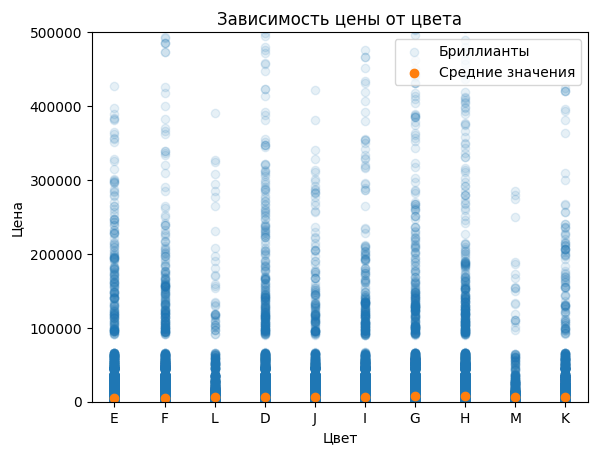

In [39]:
colored_diamonds = diamonds3[diamonds3['color'] != 'unknown']

plt.scatter(colored_diamonds['color'],
            colored_diamonds['total_sales_price'],
            alpha=0.11,
            label='Бриллианты')


means_by_color = colored_diamonds[['color', 'total_sales_price']].groupby('color').mean()
plt.scatter(means_by_color.index,
            means_by_color,
            alpha=1,
            label='Средние значения')

plt.ylim([0, 5e5])

plt.title("Зависимость цены от цвета")
plt.ylabel("Цена")
plt.xlabel('Цвет')
plt.legend(loc='upper right')

plt.show()

(2 балла) Постройте график `лабараторная оценка - кол-во бриллиантов`:

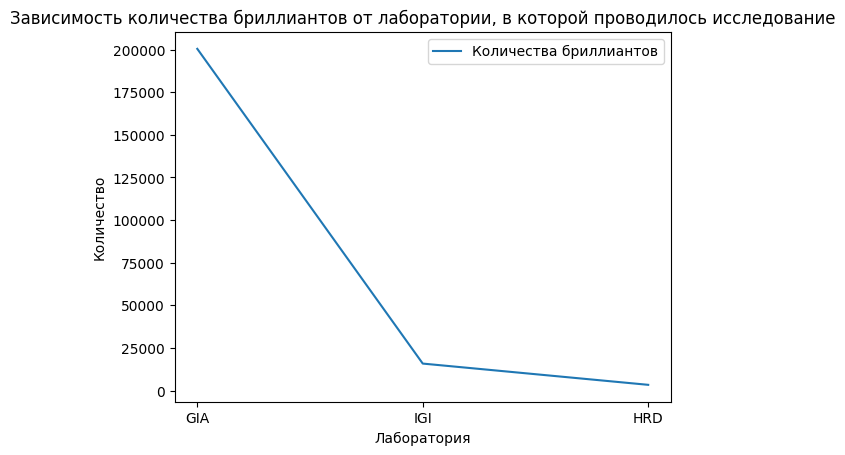

In [40]:
labs = diamonds3['lab'].value_counts()
plt.plot(labs.index,
         labs,
         label="Количества бриллиантов")

plt.title(
    "Зависимость количества бриллиантов от лаборатории,"
    " в которой проводилось исследование")

plt.ylabel("Количество")
plt.xlabel('Лаборатория')
plt.legend(loc='upper right')

plt.show()

(2 балла) Постройте график `вес бриллианта - стоимость`:

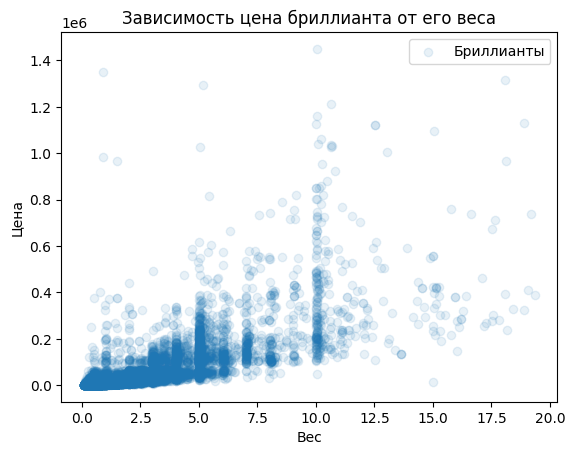

In [41]:
plt.scatter(diamonds3['carat_weight'],
            diamonds3['total_sales_price'],
            alpha=0.1,
            label="Бриллианты")

plt.title("Зависимость цена бриллианта от его веса")
plt.ylabel("Цена")
plt.xlabel('Вес')
plt.legend(loc='upper right')

plt.show()

(2 балла) Постройте график `система оценки GIA Cut - кол-во бриллиантов`:

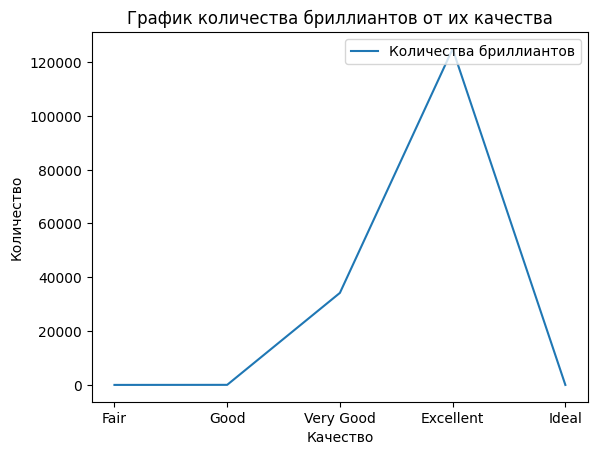

In [42]:
informative_diamonds = diamonds3[diamonds3['cut_quality'] != 'unknown']

cuts = informative_diamonds['cut_quality'].value_counts()

X = ['Fair', 'Good', 'Very Good', 'Excellent', 'Ideal']
Y = [cuts[x] for x in X]

plt.plot(X,
         Y,
         label="Количества бриллиантов")

plt.title("График количества бриллиантов от их качества")
plt.ylabel("Количество")
plt.xlabel('Качество')
plt.legend(loc='upper right')

plt.show()

(2 балла) **Сделайте выводы по построенным графикам:**

>*Подсказка для маленьких: Что вы можете сказать о графиках полученных выше для данного датасета?*

1. Цена не сильно зависит от цвета, так например, для разных цветов можно видеть примерно одинаковое распределение, к тому же, по каждому из цветов средние значения не отличаются значительно.
2. Можно видеть, что лабороатория GIA доминирует в обработке драгоценностей.
3. Несмотря на большое количество аномалий, прослеживается линейная зависимость от веса.
4. Большинство брилиантов имеют качество 'Excellent', но также много брилиантов качества 'Very Good'

## Задание 3. Модель - 30 баллов

В данном задании вам предстоит построить классифицирующую модель размер алмаза и его стоимости, а затем оценить полученную модель.

>**Примечание**
>
>Данная модель не претендует на самый верный индикатор стоимости алмаза, ведь мы не учитываем ничего больше чем стоимость алмаза. Исключительно для образовательных целей :)

Для построения модели нам понадобится 4 столбца, а именно: 
- `meas_length`
- `meas_width`
- `meas_depth`
- `total_sales_price`

От остальных столбцов можно избавиться.

(1 балл) Создайте новый датасет и выведите его первые 10 строк: 

In [43]:
diamonds_for_model = diamonds[['meas_length', 'meas_width', 'meas_depth', 'total_sales_price']]
diamonds_for_model.head(10)

,meas_length,meas_width,meas_depth,total_sales_price
0,2.85,2.87,1.79,200
1,2.84,2.89,1.78,200
2,2.88,2.90,1.77,200
3,2.86,2.88,1.78,200
4,2.79,2.83,1.82,200
5,2.95,2.99,1.81,200
6,2.85,2.88,1.84,200
7,2.86,2.89,1.78,200
8,2.89,2.92,1.85,200
9,2.83,2.87,1.80,200


(1 балл) Перемешайте строки в датафрейме случайным образом: 

In [44]:
diamonds_for_model = diamonds_for_model.sample(frac=1).reset_index(drop=True)
diamonds_for_model.head()

,meas_length,meas_width,meas_depth,total_sales_price
0,5.12,5.16,3.23,2678
1,4.77,3.46,2.27,888
2,4.48,4.51,2.83,1110
3,4.66,4.72,2.96,528
4,5.95,5.98,3.73,5112


(1 балл) Сформируем новую колонку - для каждого бриллианта найдем сумму Минковского (p=3) по 3 измерениям бриллианта:

In [45]:
x = diamonds_for_model['meas_length']
y = diamonds_for_model['meas_width']
z = diamonds_for_model['meas_depth']

diamonds_for_model['minkowski_sum'] = ((x - y).abs() ** 3 + (y - z).abs() ** 3 + (z - x).abs() ** 3) ** (1/3)
diamonds_for_model['minkowski_sum']

0         2.406717
1         2.694284
2         2.097941
3         2.180334
4         2.816052
            ...   
219698    2.450694
219699    2.274316
219700    1.855332
219701    2.059990
219702    2.430530
Name: minkowski_sum, Length: 219703, dtype: float64

(1 балл) Сформируем новый датасет из двух колонок - сумма Минковского и `total_sales_price`: 

In [46]:
diamonds_for_model = diamonds_for_model[['minkowski_sum', 'total_sales_price']]
diamonds_for_model.head()

,minkowski_sum,total_sales_price
0,2.406717,2678
1,2.694284,888
2,2.097941,1110
3,2.180334,528
4,2.816052,5112


(1 балл) Разделите вашу выборку на две части в соотношении 8:2 - одна выборка будет для тренировка, а другая для тестов вашей модели:

In [47]:
diamonds_training = diamonds_for_model.sample(frac=0.8)
diamonds_testing = diamonds_for_model.drop(diamonds_training.index)

len(diamonds_training), len(diamonds_testing)

(175762, 43941)

(2 балла) Постройте график зависимости стоимости от вашего нового параметра размера для тренинг-выборки:

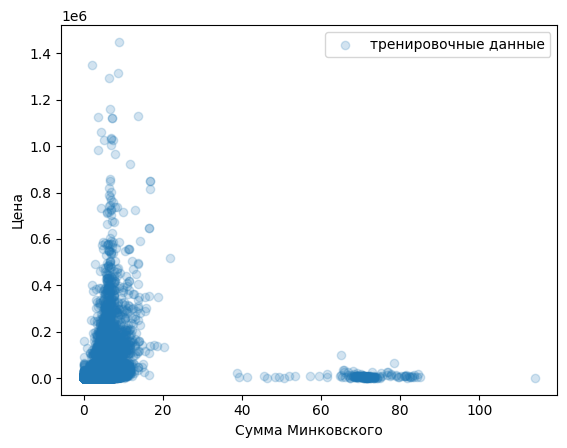

In [48]:
fig, ax = plt.subplots()
ax.scatter(diamonds_training['minkowski_sum'],
           diamonds_training['total_sales_price'],
           alpha=0.2,
           label='тренировочные данные')

ax.set_xlabel('Сумма Минковского')
ax.set_ylabel('Цена')
ax.legend(loc='upper right')

(2 балла) Нанесите на тот же график тестовую выборку, используя другой цвет (не забудьте про параметр прозрачности):

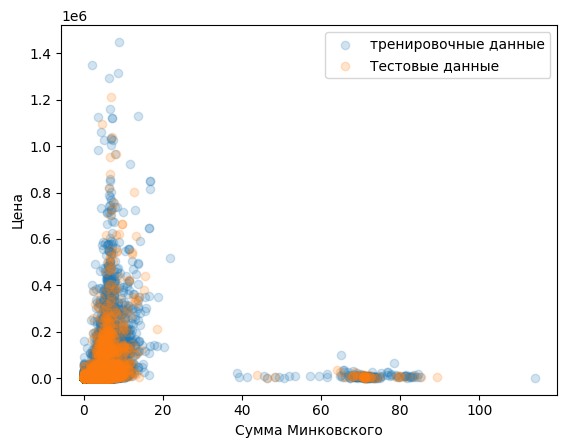

In [49]:
ax.scatter(diamonds_testing['minkowski_sum'],
           diamonds_testing['total_sales_price'],
           alpha=0.2,
           label='Тестовые данные')

ax.legend(loc='upper right')

fig

(3 балла) Найдите для каждой бриллианта из тестовой выборки его "ближайшего соседа" из тренинг-выборки. Для каждого бриллианта из тестовой выборки найдите расстояния до соответствующего ближайшего соседа:

In [50]:
id = [np.argmin(abs(diamonds_training['minkowski_sum'] - t)) for t in diamonds_testing['minkowski_sum']]

In [51]:
neighbors = diamonds_training.iloc[id].reset_index().drop(columns=['index'])
neighbors.head()

,minkowski_sum,total_sales_price
0,2.694284,804
1,2.104144,894
2,2.425497,1768
3,9.245740,21152
4,2.167138,716


(3 балла) Найдите насколько сильно (в процентах) отличается цена бриллиантов из тестовой выборки от их соответствующих ближайших соседей:

In [52]:
differences = (abs(
    diamonds_testing['total_sales_price'] - neighbors['total_sales_price'])
    / diamonds_testing['total_sales_price'])
differences.mean() * 100

363.3291879996825

In [54]:
from sklearn.metrics import mean_squared_error

f"Nearest neighbours: {mean_squared_error(diamonds_testing['total_sales_price'], neighbors['total_sales_price'])}"

'Nearest neighbours: 899924242.4144421'

**Данная модель является выдумкой автора. Не важен коэффициент ошибки, важны ваши шаги для получения коэффициента.**

### Введение в машинное обучение

Теперь давайте познакомимся с таким сильным инструментом как `sklearn`.

Вам необходимо:
1. выбрать 2 категориальных признака
2. на их основе обучить решающее дерево
3. оценить среднеквадратичную ошибку цены бриллианта
4. сделать пп. 1-3 и выбрать ту пару, которая дает лучший результат
5. сделать выводы

(3 балла) Мы работаем с категориальными признаками, для них не понятно что есть "больше" и "меньше". Поэтому нам нужно предварительно закодировать значения наших признаков, с чем нам поможет [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html):

In [55]:
# взял эти два признака для примера, потом будет перебор всех пар
X = diamonds3[['cut', 'color']]
y = diamonds3['total_sales_price']

In [56]:
from sklearn.preprocessing import OneHotEncoder


enc = OneHotEncoder(handle_unknown='ignore')
X = enc.fit_transform(X)
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

(3 балла) Разбейте датасет на обучающую и тестовую выбору. Для этого вам поможет [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html):

In [57]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

(3 балла) Затем создайте и обучите вашу модель - [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html):

In [58]:
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor(random_state=57)
clf = clf.fit(X_train, y_train)

(3 балла) Оцените ошибку вашей модели при помощи [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html):

In [59]:
from sklearn.metrics import mean_squared_error


y_pred = clf.predict(X_test)
mean_squared_error(y_test, y_pred)

676142434.3800211

(3 балла) **Сделайте выводы какие категориальные признаки лучше:**

In [60]:
categorical_attributes = ['cut', 'color', 'clarity', 'cut_quality', 'lab', 
                          'symmetry', 'polish', 'eye_clean', 
                          'girdle_min', 'girdle_max']

In [61]:
def clc_error_for_attributes(*attributes) -> float:
    X = diamonds3[list(attributes)]
    y = diamonds3['total_sales_price']
    X = OneHotEncoder(handle_unknown='ignore').fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    clf = DecisionTreeRegressor(random_state=57)
    clf = clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    return mean_squared_error(y_test, y_pred)

In [62]:
ms_errors = dict()

for i in range(len(categorical_attributes)):
  for j in range(i):
    attr1 = categorical_attributes[i]
    attr2 = categorical_attributes[j]

    ms_errors[(attr1, attr2)] = clc_error_for_attributes(attr1, attr2)

In [63]:
ms_errors

{('color', 'cut'): 553241060.0122912,
 ('clarity', 'cut'): 624306015.6326021,
 ('clarity', 'color'): 647617736.6914715,
 ('cut_quality', 'cut'): 564401795.6439008,
 ('cut_quality', 'color'): 552344428.523833,
 ('cut_quality', 'clarity'): 595750772.4547707,
 ('lab', 'cut'): 608312030.4592576,
 ('lab', 'color'): 669039956.5826942,
 ('lab', 'clarity'): 582554562.6444435,
 ('lab', 'cut_quality'): 631205844.8558102,
 ('symmetry', 'cut'): 696728475.721682,
 ('symmetry', 'color'): 719708450.406553,
 ('symmetry', 'clarity'): 577543164.5632852,
 ('symmetry', 'cut_quality'): 622533135.0400636,
 ('symmetry', 'lab'): 607175231.0142851,
 ('polish', 'cut'): 724047814.7184298,
 ('polish', 'color'): 657735131.900709,
 ('polish', 'clarity'): 619748382.8708614,
 ('polish', 'cut_quality'): 605866787.5246989,
 ('polish', 'lab'): 794946367.3819822,
 ('polish', 'symmetry'): 669500214.445427,
 ('eye_clean', 'cut'): 632377143.1232368,
 ('eye_clean', 'color'): 547528183.1174362,
 ('eye_clean', 'clarity'): 6110

In [66]:
best_attrs = min(ms_errors.items(), key=lambda item: item[1])
f"Лучший набор признаков {best_attrs[0]}, их ошибка {best_attrs[1]}"

"Лучший набор признаков ('eye_clean', 'color'), их ошибка 547528183.1174362"

In [67]:
# теперь попробуем все признаки вместе
f"Ошибка для всех признаков вместе: {clc_error_for_attributes(*categorical_attributes)}"

'Ошибка для всех признаков вместе: 867357348.6587676'

In [68]:
# попробуем загружать признаки тройками:
for i in range(len(categorical_attributes)):
  for j in range(i):
    for k in range(j):
      attr1 = categorical_attributes[i]
      attr2 = categorical_attributes[j]
      attr3 = categorical_attributes[k]

      ms_errors[(attr1, attr2, attr3)] = clc_error_for_attributes(attr1, attr2, attr3)

In [69]:
best_attrs = min(ms_errors.items(), key=lambda item: item[1])
f"Лучший набор признаков {best_attrs[0]}, их ошибка {best_attrs[1]}"

"Лучший набор признаков ('girdle_max', 'eye_clean', 'cut'), их ошибка 497955861.6982214"

*Подсказки для маленьких: Что вы можете сказать о зависимости по вашей выборке признаков? Какой вы можете сделать вывод об готовых инструментах для работы и написанных Вами?*

Подход с решающим деревом оказался значительно лучше, чем подход с ближайшими соседями (547'528'183 < 899'924'242). Лучшая пара признаков -- `eye_clean` и `color`. Если обучить дерево на всех признаках, ошибка получается гораздо больше (867'357'348), из чего можно сделать вывод, что некоторые признаки не являются содержательными и наоборот запутывают. Загрузив тройки признаков, мы улучшили результат относительно пар (497'955'861), скорее всего, если загрузить четверки, ошибка уменьшится дополнительно.